<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_09/pets_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation - segmenting images from the Oxford-IIT Pets

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb

The Oxford-IIIT Pet Dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/) is a collection of images for multi-class image classification and segmentation tasks. It includes images of 37 pet breeds, with roughly 200 images for each breed. Each image is a color photo with variations in lighting, scale, and pose, offering a challenging dataset for computer vision tasks. The dataset also provides pixel-level segmentation masks for each pet, enabling research in both classification and object segmentation.
.

You can download the dataset from the following sources:

- dataset: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz

- annotations: https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

1. Download the zip file with the data
2. Extract the zip file

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

import os
# Clean up by removing the downloaded zip file
os.remove("images.tar.gz")
os.remove("annotations.tar.gz")


--2024-11-19 14:01:12--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-11-19 14:01:14--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-19 14:01:14--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

### The format (structure) of the folders with data:
The root folder contains two main subdirectories:
- **`images/`**: Contains all the pet images for all classes in a single directory. Each image file is named according to the pet's breed (e.g., `Abyssinian_1.jpg`).
- **`annotations/`**: Contains metadata such as class labels, train-test splits, and segmentation masks.
  - **`trainval.txt`**: Contains a list of images designated for training and validation, along with their class labels and species (dog or cat).
  - **`test.txt`**: Contains a list of images reserved for testing.
  - **`trimaps/`**: Stores pixel-level segmentation masks for each image, representing:
    - Foreground
    - Background
    - Object boundaries.


## Observe the data

In [2]:
# Create lists of paths to files:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

images/yorkshire_terrier_98.jpg


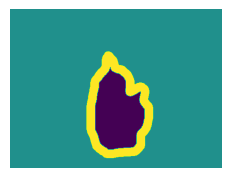

In [3]:
# View an image given by its index
image_index = -2

import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array

# print image path
print(input_img_paths[image_index])

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)

plt.axis("off")
plt.imshow(load_img(input_img_paths[image_index]))

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[image_index], color_mode="grayscale"))
display_target(img)

Input Image Path: images/Abyssinian_124.jpg
Target Image Path: annotations/trimaps/Abyssinian_124.png


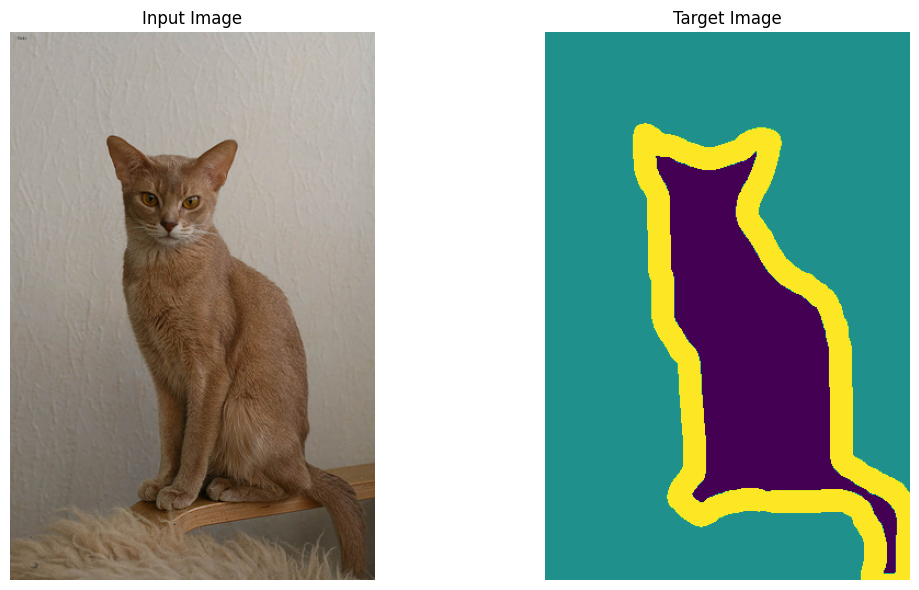

In [4]:
# View an image and its corresponding target
image_index = -2  # Change the index as needed

import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array

# View an image and its corresponding target
image_index = 28  # Change the index as needed

# Print image path
print(f"Input Image Path: {input_img_paths[image_index]}")
print(f"Target Image Path: {target_paths[image_index]}")

# Load the input image
input_img = load_img(input_img_paths[image_index])

# Load and process the target image
target_img = img_to_array(load_img(target_paths[image_index], color_mode="grayscale"))
normalized_target_img = (target_img.astype("uint8") - 1) * 127  # Normalize the target image

# Plot the images side by side
plt.figure(figsize=(12, 6))

# Display the input image
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Input Image")
plt.imshow(input_img)

# Display the target image
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Target Image")
plt.imshow(normalized_target_img[:, :, 0]) #, cmap="gray")

plt.tight_layout()
plt.show()


### Create training, validation and testing arrays


In [5]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])


num_val_samples = 1000 # number of validation and testing samples
train_input_imgs = input_imgs[:-2*num_val_samples]
train_targets = targets[:-2*num_val_samples]
val_input_imgs = input_imgs[-2*num_val_samples:-num_val_samples]
val_targets = targets[-2*num_val_samples:-num_val_samples:]
test_input_imgs = input_imgs[-num_val_samples:]
test_targets = targets[-num_val_samples:]



## Define and train the model

### Simple CNN model for binary classification:
- Start with a keras.Input layer specifying the input shape.
- Add multiple blocks of Conv2D (with 'relu' activation) followed by MaxPooling2D.
- Then add a Flatten layer to convert 2D feature maps to 1D.
- Arbitrary: Include one or more Dense layers with 'relu' (or 'tanh') activations for feature extraction.
- Use 'sigmoid' activation function in the output layer for binary classification.




In [6]:
import keras
from keras import layers
# Define the model architecture

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # encoder:
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # decoder:
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 100, 100, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Test Accuracy", "Test Loss", "Train Accuracy", "Train Loss"]
results_df = pd.DataFrame(columns=columns)

In [ ]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "pets_segm_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_pets/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################

# Define model architecture:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.SparseCategoricalCrossentropy(),
              metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")])

num_epochs = 50

checkpoint =  keras.callbacks.ModelCheckpoint(
        filepath="models/pets_segmentation.keras",
        save_best_only=True,
        monitor="val_loss")

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

history = model.fit( train_input_imgs, train_targets,
    batch_size=64,
    epochs=num_epochs,
    validation_data= (val_input_imgs, val_targets),
    callbacks=[checkpoint, tensorboard_callback])
    #callbacks=[tensorboard_callback, early_stopping])

model = keras.models.load_model("models/pets_segmentation.keras")

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_input_imgs)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_input_imgs)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_input_imgs)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

model_details = "basic"
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : test_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "pets_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 100, 100, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 200, 200, 64)        │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 200, 200, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4405s 52s/step - accuracy: 0.5544 - loss: 1.0014 - val_accuracy: 0.5832 - val_loss: 0.9949
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4413s 52s/step - accuracy: 0.5946 - loss: 0.8638 - val_accuracy: 0.6052 - val_loss: 1.0283
Epoch 3/50
21/85 ━━━━━━━━━━━━━━━━━━━━ 52:03 49s/step - accuracy: 0.6322 - loss: 0.8704

## View some segmented images

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_pets --reload_interval=1